# IV. Camera localization - Robustness to noise

In [ ]:
import torch
import math
import matplotlib.pyplot as plt
import time
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/ANAIS2023-PoseNet-Lab
!pip install tqdm
from tqdm import tqdm
from pose_resnet import *
from utils import *

Mounted at /content/drive
/content/drive/MyDrive/ANAIS2023-PoseNet-Lab
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Rotational and translation error

In [ ]:
def compute_rotational_error(q1,q2):
    q1 = q1/np.linalg.norm(q1)
    q2 = q2/np.linalg.norm(q2)
    R1 = quaternion_to_rotation_matrix(q1)
    R2 = quaternion_to_rotation_matrix(q2)
    rot_error = np.rad2deg(math.acos(0.5*(np.trace(R1.T@R2)-1)))
    return rot_error

def compute_translational_error(t1,t2):
    return math.sqrt(sum((t1-t2)**2))

## Add noise to image

In [ ]:
def add_noise(image, mean=0., std=1.):
    noise = torch.randn(image.size()) * std + mean
    noisy_image = image + noise
    #noisy_image = torch.clamp(noisy_image, 0., 1.)  # clip values to [0, 1] range
    return noisy_image

## Main

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 65.5MB/s]
100%|██████████| 1715/1715 [07:42<00:00,  3.71iteration/s]


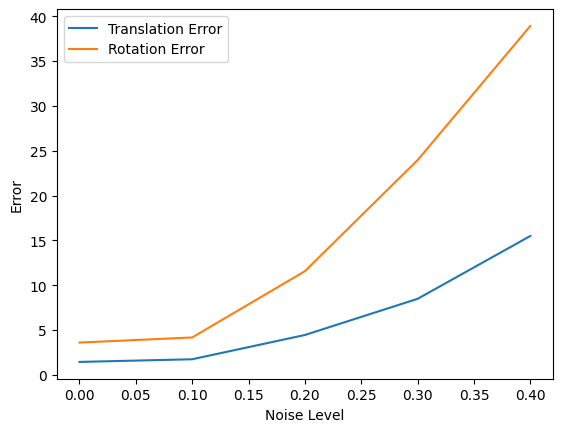

In [ ]:
def main():
    # load the model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = PoseResNet().to(device)
    model.load_state_dict(torch.load("posenet_weigths.pth", map_location=device))
    model.eval().to(device)

    # Load the image
    root_dir = "/content/drive/MyDrive/ANAIS2023-PoseNet-Lab/KingsCollege/"
    nb_im =  len([line for line in open(root_dir + "dataset_test.txt")]) - 3
    noise_std_level = [0., 0.1, 0.2, 0.3, 0.4]
    progress_bar = tqdm(total=nb_im*len(noise_std_level), unit='iteration')
    list_rob_rot = []; list_rob_trans = []

    for noise_std in noise_std_level:
        list_err_rot = []; list_err_trans = []
        for i in range(nb_im):
            image, pose = load_single_image_and_pose(root_dir, root_dir + "dataset_test.txt", i)
            # add noise
            image = add_noise(image,0,noise_std)
            # Run the model on the image
            image = image.to(device)
            pose = pose.to(device)
            output = model(image)
            # Compute the rotational and translational error
            pred_pose = output.detach().cpu().numpy()[0]
            gt_pose = pose.detach().cpu().numpy()[0]
            q_pred, t_pred = pred_pose[3:7], pred_pose[:3]
            q_gt, t_gt = gt_pose[3:7], gt_pose[:3]
            err_rot = compute_rotational_error(q_pred,q_gt)
            err_trans = compute_translational_error(t_pred,t_gt)

            #save in lists
            list_err_rot.append(err_rot)
            list_err_trans.append(err_trans)
            progress_bar.update(1)
        
        list_rob_rot.append(np.median(list_err_rot))
        list_rob_trans.append(np.median(list_err_trans))
    progress_bar.close()

    # Plot the errors
    plt.figure()
    plt.plot(noise_std_level, list_rob_trans, label='Translation Error')
    plt.plot(noise_std_level, list_rob_rot, label='Rotation Error')
    plt.xlabel('Noise Level')
    plt.ylabel('Error')
    plt.legend()
    plt.show()
    

if __name__ == "__main__":
    main()